In [2]:
from scipy.stats import norm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import squarify    # pip install squarify (algorithm for treemap)
from matplotlib.gridspec import GridSpec
from sklearn.linear_model import LogisticRegression

---

<ipython-input-54-893a3b4d952a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anticorpos'][df.doente==1] = norm.rvs(loc=doente_mu, scale=doente_sigma, size=n_doentes, random_state=None)


Text(0.5, 1.0, 'ROC')

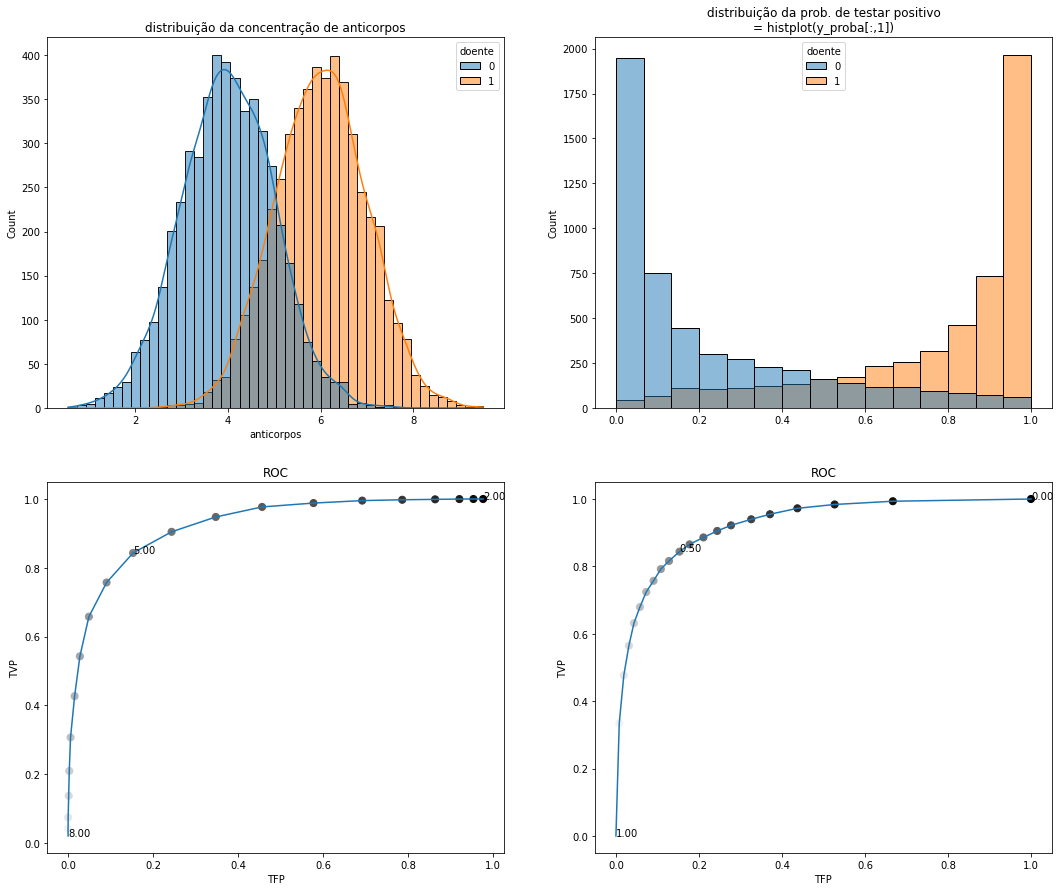

In [54]:
prop = 0.5
pop = 10_000
n_doentes = int(pop*prop)
n_saldaveis = int(pop*(1-prop))
doente_mu = 6
saudavel_mu = 4
doente_sigma = 1
saudavel_sigma = 1

threshold_points = 21


df = pd.DataFrame()
df['doente'] = pd.Series([0]*n_saldaveis + [1]*n_doentes)

df['anticorpos'] = norm.rvs(loc=saudavel_mu, scale=saudavel_sigma, size=pop, random_state=None)
df['anticorpos'][df.doente==1] = norm.rvs(loc=doente_mu, scale=doente_sigma, size=n_doentes, random_state=None)

fig = plt.figure(figsize=(18,15))
gs = GridSpec(ncols=2, nrows=2)
plot1 = fig.add_subplot(gs[0, 0])
plot2 = fig.add_subplot(gs[0, 1])
plot3 = fig.add_subplot(gs[1, 0])
plot4 = fig.add_subplot(gs[1, 1])

sns.histplot(x=df.anticorpos, hue=df.doente, kde=True, ax=plot1).set_title("distribuição da concentração de anticorpos")

X = df[['anticorpos']]
y = df['doente']
clf = LogisticRegression().fit(X, y)
y_proba = clf.predict_proba(X)

sns.histplot(x=y_proba[:,1], hue=df.doente, kde=False, ax=plot2).set_title("distribuição da prob. de testar positivo\n= histplot(y_proba[:,1])")

normal_thresholds = np.linspace(saudavel_mu-2*saudavel_sigma, doente_mu+2*doente_sigma, threshold_points)
TVPs = []
TFPs = []
for threshold in normal_thresholds:
  df['previsao_normal'] = df['anticorpos']>threshold
  df['previsao_normal'] = df['previsao_normal'].map(int)

  vp = df[(df.doente==1)&(df.previsao_normal==1)].shape[0]
  vn = df[(df.doente==0)&(df.previsao_normal==0)].shape[0]
  fp = df[(df.doente==0)&(df.previsao_normal==1)].shape[0]
  fn = df[(df.doente==1)&(df.previsao_normal==0)].shape[0]

  TVPs += [vp/(vp+fn)]
  TFPs += [fp/(vn+fp)]

normal_coefs_df = pd.DataFrame()
normal_coefs_df['TVP'] = TVPs
normal_coefs_df['TFP'] = TFPs
normal_coefs_df['normal_thresholds'] = normal_thresholds
normal_coefs_df.set_index('normal_thresholds', inplace=True)

plot3.scatter(normal_coefs_df['TFP'], normal_coefs_df['TVP'], s=50, c=normal_coefs_df.index, cmap='gray')
for threshold in normal_thresholds[::10]:
  plot3.annotate(f'{threshold:.2f}', (normal_coefs_df['TFP'][threshold], normal_coefs_df['TVP'][threshold]))
plot3.plot(normal_coefs_df['TFP'], normal_coefs_df['TVP'])
plot3.set_xlabel("TFP")
plot3.set_ylabel("TVP")
plot3.set_title("ROC")








logistic_thresholds = np.linspace(0,1,threshold_points)
TVPs = []
TFPs = []

for threshold in logistic_thresholds:
  df['previsao_logistica'] = y_proba[:,1]>threshold
  df['previsao_logistica'] = df['previsao_logistica'].map(int)

  vp = df[(df.doente==1)&(df.previsao_logistica==1)].shape[0]
  vn = df[(df.doente==0)&(df.previsao_logistica==0)].shape[0]
  fp = df[(df.doente==0)&(df.previsao_logistica==1)].shape[0]
  fn = df[(df.doente==1)&(df.previsao_logistica==0)].shape[0]

  TVPs += [vp/(vp+fn)]
  TFPs += [fp/(vn+fp)]

logistic_coefs_df = pd.DataFrame()
logistic_coefs_df['TVP'] = TVPs
logistic_coefs_df['TFP'] = TFPs
logistic_coefs_df['logistic_thresholds'] = logistic_thresholds
logistic_coefs_df.set_index('logistic_thresholds', inplace=True)
# logistic_coefs_df

# sns.lineplot(x=logistic_coefs_df['TFP'], y=logistic_coefs_df['TVP'], ax=plot3, marker="o").set_title("ROC")
# plot3.set(xlabel='TFP', ylabel='TPV')

plot4.scatter(logistic_coefs_df['TFP'], logistic_coefs_df['TVP'], s=50, c=logistic_coefs_df.index, cmap='gray')
for threshold in logistic_thresholds[::10]:
  plot4.annotate(f'{threshold:.2f}', (logistic_coefs_df['TFP'][threshold], logistic_coefs_df['TVP'][threshold]))
plot4.plot(logistic_coefs_df['TFP'], logistic_coefs_df['TVP'])
plot4.set_xlabel("TFP")
plot4.set_ylabel("TVP")
plot4.set_title("ROC")


##################################################################################################################
##################################################################################################################
##################################################################################################################

# sns.lineplot(x=df_t.index, y=df_t['TVP']/df_t['TFP'], ax=plot4, marker="o").set_title("TVP/TFP")
# plot4.set(xlabel='thresholds', ylabel='TVP/TFP')

# plot4.scatter(thresholds, df_t['TVP']/(df_t['TFP']+df_t['TVP']), s=50, c=df_t.index, cmap='gray')
# for threshold in thresholds:
#   plot4.annotate(f'{threshold:.2f}', (threshold, df_t['TVP'][threshold]/(df_t['TFP'][threshold]+df_t['TVP'][threshold])))
# plot4.plot(thresholds, df_t['TVP']/(df_t['TFP']+df_t['TVP']))
# plot4.set_xlabel("thresholds")
# plot4.set_ylabel("TVP/(TFP+TVP)")
# plot4.set_title("TVP/(TFP+TVP)")



---

In [3]:
def plot_tree_maps(P_vn, P_fp, P_fn, P_vp, plot1, plot2, plot3, plot4, plot5):

  def stringfy(num):
    if (num>1000000):
      return f"{num/1000000:.1f}MM"
    if (num>1000):
      return f"{num/1000:.0f}M"
    return f"{int(num)}"
  
  def percentify(df):
    total = df['size'].sum()
    df['percent'] = round(100*df['size']/total,1)
    df['percent'] = df['percent'].map(str)
  
  def create_label(df):
    percentify(df)
    return df['percent']+'% '+df['label']

  VN = int(P_vn * 200_000_000)
  FP = int(P_fp * 200_000_000)
  FN = int(P_fn * 200_000_000)
  VP = int(P_vp * 200_000_000)

  df_square = pd.DataFrame({
    'size':[VN,FP,VP,FN],
    'label':[f"VN\n{stringfy(VN)}", f"FP\n{stringfy(FP)}", f"VP\n{stringfy(VP)}", f"FN\n{stringfy(FN)}"],
    # 'color':["green","darkorange","indianred", "darkred"],
    'color':["green","blue","orange", "red"],
    'type':['VN','FP','VP','FN']
  })

  alpha = .5


  positive_test_mask = ((df_square['type']=='VP') | (df_square['type']=='FP'))
  negative_test_mask = (~positive_test_mask)
  diseased_mask = ((df_square['type']=='VP') | (df_square['type']=='FN'))
  not_diseased_mask = (~diseased_mask)

  # Todos os grupos
  plot1.axis('off')
  plot1.set_title('População toda')
  squarify.plot(sizes=df_square['size'], label=create_label(df_square), color=df_square['color'], alpha=alpha, ax=plot1)

  # Apenas testes positivos
  plot2.axis('off')
  plot2.set_title('Testes positivos')
  df_temp = df_square[positive_test_mask].copy()
  squarify.plot(sizes=df_temp['size'], label=create_label(df_temp), color=df_temp['color'], alpha=alpha, ax=plot2)

  # Apenas testes negativos
  plot3.axis('off')
  plot3.set_title('Testes negativos')
  df_temp = df_square[negative_test_mask].copy()
  squarify.plot(sizes=df_temp['size'], label=create_label(df_temp), color=df_temp['color'], alpha=alpha, ax=plot3)

  # Apenas pessoas doentes
  plot4.axis('off')
  plot4.set_title('Doentes')
  df_temp = df_square[diseased_mask].copy()
  squarify.plot(sizes=df_temp['size'], label=create_label(df_temp), color=df_temp['color'], alpha=alpha, ax=plot4)

  # Apenas pessoas saudáveis
  plot5.axis('off')
  plot5.set_title('Saudáveis')
  df_temp = df_square[not_diseased_mask].copy()
  squarify.plot(sizes=df_temp['size'], label=create_label(df_temp), color=df_temp['color'], alpha=alpha, ax=plot5)

In [4]:
# formata float como % com 2 casas decimais
def percentify(val):
    return f'{100*val:.2f}%'

# Discretização do eixo X
xs_glob = list(np.linspace(0,12,100))

def plot_pdfs(mu_doente, sigma_doente, mu_saudavel, sigma_saudavel, prop, threshold, fill_positives=False):

    # Truque pra usar menos pontos e mesmo assim hachurar a área bonitinho
    xs = pd.Series([threshold-0.001,threshold+0.001]+xs_glob).sort_values()

    threshold_index = np.where(xs>threshold)[0][0]
    fig = plt.figure(figsize=(22,11))
    gs = GridSpec(ncols=5, nrows=4, hspace=.4, height_ratios=[2,1,1,2])
    plot = fig.add_subplot(gs[0:2,:4])
    matrix = fig.add_subplot(gs[0,4:])
    coefs = fig.add_subplot(gs[2,:4])
    roc_plot = fig.add_subplot(gs[1:3,4:])

    plot1 = fig.add_subplot(gs[3,0])
    plot2 = fig.add_subplot(gs[3,1])
    plot3 = fig.add_subplot(gs[3,2])
    plot4 = fig.add_subplot(gs[3,3])
    plot5 = fig.add_subplot(gs[3,4])
    
    # valores da PDF para os DOENTES
    y1s = norm.pdf(xs, loc=mu_doente, scale=sigma_doente)*prop
    plot.plot(xs, y1s, label="Distribuição doentes", color='darkorange')
    # hachurar os falsos negativos
    falsos_negativos = np.array((list(y1s[:threshold_index]) + list([0.0]*(len(xs)-threshold_index))))
    plot.fill_between(xs, falsos_negativos, alpha=0.5, label="Prob. falsos negativos", color='red')
    
    # valores da PDF para os NÃO DOENTES
    y2s = norm.pdf(xs, loc=mu_saudavel, scale=sigma_saudavel)*(1-prop)
    plot.plot(xs, y2s, label="Distribuição saudáveis", color='darkgreen')
    # hachurar os falsos positivos
    falsos_positivos = np.array((list([0.0]*threshold_index) + list(y2s[threshold_index:])))
    plot.fill_between(xs, falsos_positivos, alpha=0.5, label="Prob. falsos positivos", color='blue')

    if fill_positives:
        # hachurar os verdadeiros positivos
        verdadeiros_positivos = np.array((list([0.0]*threshold_index) + list(y1s[threshold_index:])))
        plot.fill_between(xs, verdadeiros_positivos, alpha=1, label="Prob. verdadeiros positivos", facecolor="none", edgecolor='darkorange',hatch="//")

        # hachurar os verdadeiros negativos
        verdadeiros_negativos = np.array((list(y2s[:threshold_index]) + list([0.0]*(len(xs)-threshold_index))))
        plot.fill_between(xs, verdadeiros_negativos, alpha=1, label="Prob. verdadeiros positivos", facecolor="none", edgecolor='green',hatch="\\\\")
    
    # linha vertical de limiar/threshold
    plot.axvline(threshold, 0, 1, color='black', alpha=200, label="Threshold ou Limiar [positivos | negativos]")
    
    # legendas
    plot.legend()

    # fig.title("Distribuições das respostas ao teste")
    
    # Cálculo das probabilidades
    P_vp = norm.sf(xs[threshold_index], loc=mu_doente, scale=sigma_doente)*prop      # verdadeiro positivo
    P_fn = norm.cdf(xs[threshold_index], loc=mu_doente, scale=sigma_doente)*prop       # falso positivo
    P_vn = norm.cdf(xs[threshold_index], loc=mu_saudavel, scale=sigma_saudavel)*(1-prop)   # verdadeiro negativo
    P_fp = norm.sf(xs[threshold_index], loc=mu_saudavel, scale=sigma_saudavel)*(1-prop)  # falso negativo
    
    # Criando matriz de confusão
    df_conf = pd.DataFrame()
    df_conf['Teste negativo'] = [P_vn,P_fn]
    df_conf['Teste positivo'] = [P_fp,P_vp]
    df_conf['idx'] = ['Não doente','Doente']
    df_conf.set_index('idx',inplace=True)

    sns.heatmap(df_conf, annot=True, ax=matrix, cmap="Blues")

    # Construção da matriz de confusão
    d = [
        {'Real':'Positivo', 'Teste positivo':percentify(P_vp), 'Teste negativo':percentify(P_fn), '  % da pop.':percentify(P_vp+P_fn)},
        {'Real':'Negativo', 'Teste positivo':percentify(P_fp), 'Teste negativo':percentify(P_vn), '  % da pop.':percentify(P_fp+P_vn)},
        {'Real':'% da pop.', 'Teste positivo':percentify(P_vp+P_fp), 'Teste negativo':percentify(P_fn+P_vn), '  % da pop.':percentify(P_vp+P_fn+P_fp+P_vn)}
    ]
    print(pd.DataFrame(d).set_index('Real'))
    print('-'*100)
    
    # Cálculo dos indicadores de qualidade do teste
    sensitivity = P_vp/(P_vp+P_fn)    # prob. de classificar corretamente alguém como positivo
    specificity = P_vn/(P_vn+P_fp)    # prob. de classificar corretamente alguém como negativo
    PPV = P_vp/(P_vp+P_fp)            # prob. de ser positivo dado que o teste deu positivo
    NPV = P_vn/(P_vn+P_fn)            # prob. de ser negativo dado que o teste deu negativo
    print(f"Precision/PPV: {100*PPV:.2f}%   NPV: {100*NPV:.2f}%   sensitivity: {100*sensitivity:.2f}%   specificity: {100*specificity:.2f}%")


    precisao = P_vp/(P_vp+P_fp)
    sensibilidade = P_vp/(P_vp+P_fn)
    especificidade = P_vn/(P_vn+P_fp)
    TFP = P_fp/(P_vn+P_fp)
    df_coefs = pd.DataFrame()
    df_coefs['precisao'] = [precisao]
    df_coefs['especificidade'] = [especificidade]
    df_coefs['sensibilidade / TVP'] = [sensibilidade]
    df_coefs['TFP'] = [TFP]
    sns.heatmap(df_coefs, annot=True, ax=coefs, cmap="Blues")


    df_roc = pd.DataFrame()
    df_roc['thresholds'] = np.linspace(-3,13,100)

    df_roc['P_vp'] = norm.sf(df_roc['thresholds'], loc=mu_doente, scale=sigma_doente)*prop      # verdadeiro positivo
    df_roc['P_fn'] = norm.cdf(df_roc['thresholds'], loc=mu_doente, scale=sigma_doente)*prop       # falso positivo
    df_roc['P_vn'] = norm.cdf(df_roc['thresholds'], loc=mu_saudavel, scale=sigma_saudavel)*(1-prop)   # verdadeiro negativo
    df_roc['P_fp'] = norm.sf(df_roc['thresholds'], loc=mu_saudavel, scale=sigma_saudavel)*(1-prop)  # falso negativo
    df_roc['TVP'] = df_roc['P_vp']/(df_roc['P_vp']+df_roc['P_fn'])
    df_roc['TFP'] = df_roc['P_fp']/(df_roc['P_vn']+df_roc['P_fp'])
    
    # sns.lineplot(x=df_roc['TFP'],y=df_roc['TVP'], ax=roc_plot)
    roc_plot.plot(df_roc['TFP'],df_roc['TVP'], marker='x')
    roc_plot.set_title('ROC')

    # Labels
    roc_plot.set_xlabel("TFP")
    roc_plot.set_ylabel("TVP")

    # Limites
    lim_inf = -0.1
    lim_sup = 1.1
    roc_plot.set_xlim(lim_inf, lim_sup)
    roc_plot.set_ylim(lim_inf, lim_sup)

    # tracejados da caixa
    if(lim_inf<0 and lim_sup>1):
        roc_plot.plot([0, 0], [lim_inf, lim_sup], linestyle="--", alpha=0.5, color='#888888')
        roc_plot.plot([1, 1], [lim_inf, lim_sup], linestyle="--", alpha=0.5, color='#888888')
        roc_plot.plot([lim_inf, lim_sup], [0, 0], linestyle="--", alpha=0.5, color='#888888')
        roc_plot.plot([lim_inf, lim_sup], [1, 1], linestyle="--", alpha=0.5, color='#888888')

    # ponto
    x_p = df_coefs['TFP'][0]
    y_p = df_coefs['sensibilidade / TVP'][0]
    roc_plot.scatter(x_p, y_p)

    # ticks 
    ticks = []
    roc_plot.set_xticks(ticks+[df_coefs['TFP'][0]])
    roc_plot.set_yticks(ticks+[df_coefs['sensibilidade / TVP'][0]])

    # linhas guia
    roc_plot.plot([x_p, x_p], [lim_inf, y_p], linestyle="--", alpha=0.75, color='#000000')
    roc_plot.plot([lim_inf, x_p], [y_p, y_p], linestyle="--", alpha=0.75, color='#000000')



    # Treemaps
    plot_tree_maps(P_vn, P_fp, P_fn, P_vp, plot1, plot2, plot3, plot4, plot5)

# Imagine que você precisa criar um teste para uma doença...

## Notebook interativo pra testar o efeito de diversos fatores como:
  - Proporção entre pessas doentes e não doentes: `prop`
    - ex.: se a doença afeta 10% da população, deixar em 0.1
  - Médias dos resultados dos testes: `mu_doente, mu_saudavel`
  - Desvios dos resultados dos testes: `sigma_doente, sigma_saudavel`
  - Limiar para resultado do teste: `threshold`

## Exemplos de efeitos observados:
  - Separar as médias ou reduzir os desvios melhora a qualidade dos testes e faz a ROC tender ao ideal
  - Aproximar as médias ou aumentar os desvios piora os testes e aproxima a ROC da linha diagonal
  - Diminuir o `threshold` leva o ponto sob a ROC em direção ao extremo (0,0) e aumentar leva em direção ao extremo (1,1)
  - O valor de `threshold` controla sua relação de `falsos negativos` e `falsos positivos`
  - bla, bla, bla...

In [5]:
# Configurando sliders interativos
interact(
    plot_pdfs,
    mu_doente=widgets.IntSlider(min=0, max=10, step=1, value=6),
    sigma_doente=widgets.FloatSlider(min=0.1, max=5, step=.1, value=1.0),
    mu_saudavel=widgets.IntSlider(min=0, max=10, step=1, value=4),
    sigma_saudavel=widgets.FloatSlider(min=0.1, max=5, step=.1, value=1.0),
    prop=widgets.FloatSlider(min=0.01, max=0.99, step=.01, value=0.5),
    threshold=widgets.FloatSlider(min=0, max=10, step=.25, value=5),
    fill_positives=False
);


interactive(children=(IntSlider(value=6, description='mu_doente', max=10), FloatSlider(value=1.0, description=…

- ***Precision / PPV*** (Positive Predictive Value) is the percentage of patients with a positive test who actually have the disease
$$Precision = PPV = \frac{TP}{TP + FP}$$
- ***NPV*** (Negative Predictive Value) is the percentage of patients with a negative test who do not have the disease
$$NPV = \frac{TN}{FN + TN}$$
- ***Specificity*** is the ability of a test to correctly classify an individual as disease-free
$$Specificity  = \frac{TN}{TN + FP}$$
- ***Sensitivity / TPR*** (True Positive Rate) is the ability of a test to correctly classify an individual as ′diseased′ 
$$Sensitivity = TPR = \frac{TP}{TP + FN} = [TVP (Taxa de Verdadeiros Positivos)]$$
- ***FPR*** (False Positive Rate) ***/ False alarm ratio***
$$FPR = \frac{FP}{FP + TN} = [TFP (Taxa de Falsos Positivos)]$$
> [fonte: Understanding and using sensitivity, specificity and predictive values](https://www.delftstack.com/howto/seaborn/legend-seaborn-plot/)

### Obs:
- Mudar a proporção entre `DOENTES` e `NÃO DOENTES` afeta `PPV` e `NPV`, mas **não** afeta `Specificity` e `Sensitivity`
- Mesmo deixando tudo simétrico, pode ser que os valores fiquem com uma pequena diferença causada pela discretização grosseira do eixo X

---

# Minha dúvida: O balanço (`prop`) não tem nenhum efeito sobre ROC mesmo?

---